<a href="https://colab.research.google.com/github/HalgasAdrian/CS5230-Coursework/blob/main/HW2B%20Clustering%20DBSCAN%2C%20Hierarchical%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROBLEM 5: DBSCAN on toy-neighborhood data**

You are to cluster, and visualize, a small dataset using DBSCAN epsilon = 7.5, MinPts = 3). You have been provided a file, dbscan.csv, that has the following columns for each point in the dataset:

cluster originally empty, provided for your convenience pt a unique id for each data point

x point x-coordinate

y point y-coordinate

num neighbors number of neighbors, according to the coordinates above neighbors the id’s of all neighbors within

As you can see, a tedious O(n^2) portion of the work has been done for you. Your job is to execute, point-by-point, the DBSCAN algorithm, logging your work.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [2]:
# Loading data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/dbscan.csv'
data = pd.read_csv(url)  # Read into a DataFrame
print(data.head())  # Preview first few rows

# Convert to NumPy array (excluding non-numeric columns)
numeric_data = data.select_dtypes(include=['number']).to_numpy()
print(f"Numeric data shape: {numeric_data.shape}")

   cluster  pt          x          y  num_neighbors neighbors
0      NaN   0  51.418089  13.593610              2      0,27
1      NaN   1  39.132318  -4.419204              3   1,40,75
2      NaN   2  47.807515 -25.822561              1         2
3      NaN   3  27.699703  53.434193              1         3
4      NaN   4  39.860995   5.676871              3   4,56,75
Numeric data shape: (80, 5)


In [3]:
# Initialize DBSCAN Parameters
epsilon = 7.5
minPts = 3

# Define Cluster Labels
cluster_assignments = {}  # Dictionary to track cluster assignments

# Cluster tracking
current_cluster = 0
noise = 0

# Convert NaN cluster values to None (unvisited)
data['cluster'] = None

In [4]:
# Function to expand a cluster recursively
def expand_cluster(point_index, cluster_id):
    """
    Expands a given cluster by checking the neighbors and
    adding core points to the cluster.
    """
    neighbors_to_visit = data.loc[point_index, 'neighbors']

    if isinstance(neighbors_to_visit, str):
        neighbors_to_visit = list(map(int, neighbors_to_visit.split(',')))  # Convert string of neighbors into a list

    while neighbors_to_visit:
        neighbor_id = neighbors_to_visit.pop()  # Get a neighbor
        neighbor_index = data.index[data['pt'] == neighbor_id].tolist()[0]  # Get the row index

        if data.at[neighbor_index, 'cluster'] is None:  # If not yet assigned
            data.at[neighbor_index, 'cluster'] = cluster_id  # Assign to cluster

            # If neighbor is also a core point, expand further
            num_neighbors = data.at[neighbor_index, 'num_neighbors']
            if num_neighbors >= minPts:
                more_neighbors = data.at[neighbor_index, 'neighbors']
                if isinstance(more_neighbors, str):
                    more_neighbors = list(map(int, more_neighbors.split(',')))
                    neighbors_to_visit.extend(more_neighbors)  # Expand cluster

In [5]:
# DBSCAN Algorithm
for index, row in data.iterrows():
    if data.at[index, 'cluster'] is not None:  # Skip if already assigned
        continue

    num_neighbors = row['num_neighbors']

    if num_neighbors < minPts:
        data.at[index, 'cluster'] = noise  # Mark as noise (outlier)
    else:
        current_cluster += 1  # Create a new cluster
        data.at[index, 'cluster'] = current_cluster  # Assign cluster
        expand_cluster(index, current_cluster)  # Expand cluster

# Display the final clustered data
display(data)

,cluster,pt,x,y,num_neighbors,neighbors
0,0,0,51.418089,13.593610,2,"0,27"
1,1,1,39.132318,-4.419204,3,"1,40,75"
2,0,2,47.807515,-25.822561,1,2
3,0,3,27.699703,53.434193,1,3
4,1,4,39.860995,5.676871,3,"4,56,75"
...,...,...,...,...,...,...
75,1,75,39.659047,0.230178,3,"1,4,75"
76,2,76,26.366491,8.798826,3,"21,49,76"
77,0,77,-36.184060,44.292045,2,"55,77"
78,3,78,44.012085,37.729478,3,"9,33,78"


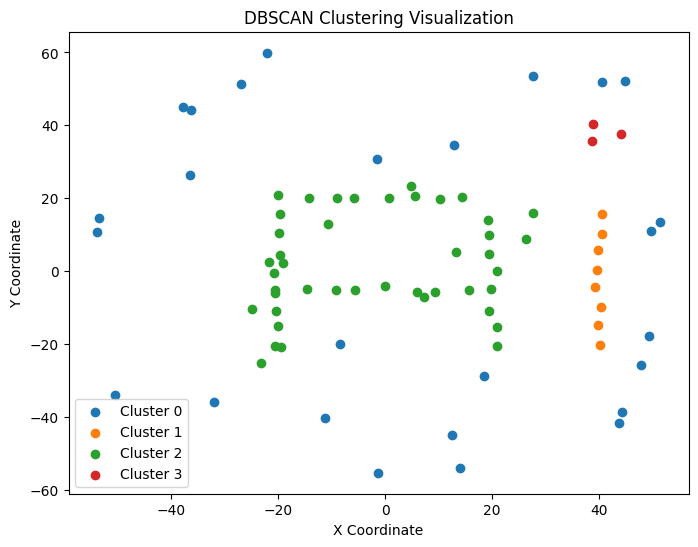

In [6]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))

# Plot each cluster with a different color
for cluster_id in data['cluster'].unique():
    cluster_points = data[data['cluster'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f"Cluster {cluster_id}")

# Formatting
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('DBSCAN Clustering Visualization')
plt.legend()
plt.show()

**PROBLEM 6: DBSCAN on toy raw data**

Three toy 2D datasets are provided (or they can be obtained easily with scikit learn) circles; blobs, and moons. Run your own implementation of DBSCAN on these, in two phases.


In [7]:
# Start with generating our datasets
from sklearn.datasets import make_circles, make_blobs, make_moons

# Synthetic datasets
datasets = {
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    'Blobs': make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42),
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)
}

In [8]:
# DBSCAN Parameters for each dataset
dbscan_params = {
    "Circles": {"epsilon": 0.2, "minPts": 5},
    "Blobs": {"epsilon": 1.5, "minPts": 6},
    "Moons": {"epsilon": 0.2, "minPts": 5},
}

# DBSCAN Algorithm
def dbscan(X, epsilon, minPts):
    """
    DBSCAN Implementation for clustering 2D points.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        neighbors = region_query(point_idx)
        if len(neighbors) < minPts:
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = neighbors.copy()
            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id  # Assign to cluster
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= minPts:
                        queue.extend(new_neighbors)  # Expand the cluster
            return True

    # Function to find neighbors within epsilon radius
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= epsilon)[0].tolist()

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1

    return np.array(clusters)

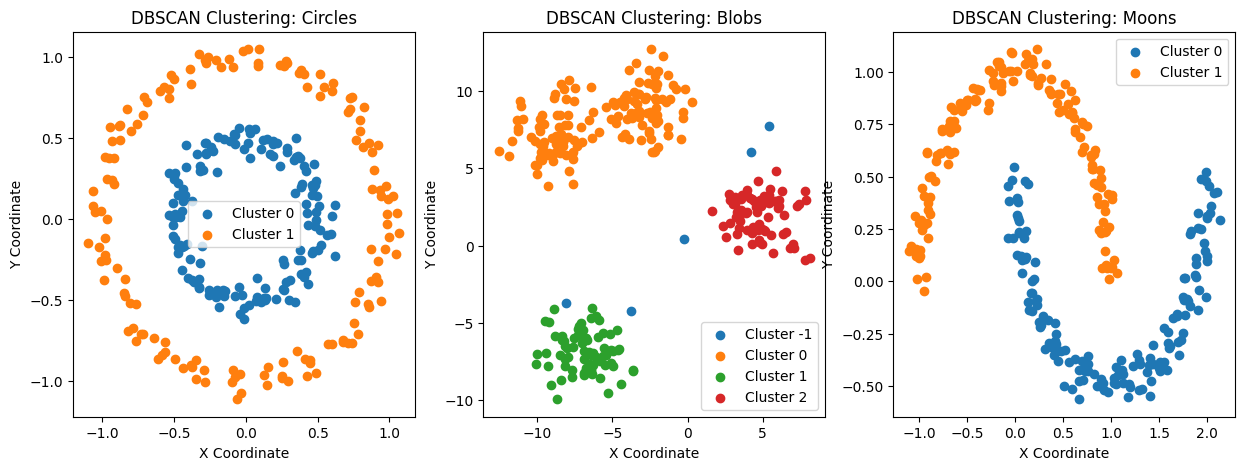

In [9]:
# Apply DBSCAN to Each Dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, (X, _)) in enumerate(datasets.items()):
    params = dbscan_params[name]
    labels = dbscan(X, params["epsilon"], params["minPts"])
    unique_clusters = np.unique(labels)

    # Plot Clusters
    plt.subplot(1, 3, i + 1)
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot Formatting
    plt.title(f"DBSCAN Clustering: {name}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()

plt.show()

**PROBLEM 7: DBSCAN on real data**

Run the DBSCAN algorithm on the 20NG dataset, and on the FASHION dataset, and the HouseHold dataset (see papers), and evaluate results. You need to implement both phases (1) neighborhoods creation, (2) DBSCAN.

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf
import seaborn as sns
from sklearn.manifold import TSNE
import urllib.request
import zipfile

# Enable GPU Acceleration for Fashion-MNIST
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Note on TF-IDF Vectorization: Term Frequency-Inverse Document Frequency is a text representation technique that evaluates how importat a word is to a document relative to a corpus.

Term Frequency (TF) = (word count in doc) / (total words in doc) - measures local importance of a word

Inverse document frequency (IDF) = log(total docs / docs containing word) - penalizes words common across many docs

TF-IDF = TF * IDF - final importance score for each word

TfidVectorizer automatically applies L2 Normalization to our output vectors.

In [16]:
print("Loading 20 Newsgroups dataset...")
newsgroups = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"))

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_20ng = vectorizer.fit_transform(newsgroups.data).toarray()

# Apply PCA to Reduce Dimensionality (5000 → 50)
print("Applying PCA to 20NG dataset...")
pca_20ng = PCA(n_components=50)
X_20ng_reduced = pca_20ng.fit_transform(X_20ng)

# Normalize the dataset
X_20ng_reduced = StandardScaler().fit_transform(X_20ng_reduced)

print(f"20 Newsgroups dataset shape after PCA: {X_20ng_reduced.shape}")

Loading 20 Newsgroups dataset...
Applying PCA to 20NG dataset...
20 Newsgroups dataset shape after PCA: (18846, 50)


In [17]:
print("Loading Fashion-MNIST dataset...")
(X_train, _), (_, _) = fashion_mnist.load_data()

# Flatten images and normalize
X_fashion = X_train.reshape(X_train.shape[0], -1) / 255.0

print(f"Fashion-MNIST dataset shape: {X_fashion.shape}")

Loading Fashion-MNIST dataset...
Fashion-MNIST dataset shape: (60000, 784)


In [18]:
# Reduce Fashion-MNIST dimensions further for DBSCAN speedup
print("Applying PCA to Fashion-MNIST dataset...")

pca_fashion = PCA(n_components=20)  # Reduce to 20D for faster DBSCAN
X_fashion_reduced = pca_fashion.fit_transform(X_fashion)

print(f"Fashion-MNIST dataset shape after PCA: {X_fashion_reduced.shape}")

Applying PCA to Fashion-MNIST dataset...
Fashion-MNIST dataset shape after PCA: (60000, 20)


In [19]:
# Download dataset
urllib.request.urlretrieve(
    "https://archive.ics.uci.edu/static/public/235/individual+household+electric+power+consumption.zip",
    "household_power_data.zip"
)

# Extract dataset
with zipfile.ZipFile("household_power_data.zip", "r") as zip_ref:
    zip_ref.extractall()

# Load dataset
file_path = "household_power_consumption.txt"
household_data = pd.read_csv(
    file_path, sep=";", low_memory=False, na_values="?",
    parse_dates={"Datetime": ["Date", "Time"]}, infer_datetime_format=True
)

# Drop rows with missing values
household_data.dropna(inplace=True)

# Select relevant numerical columns
features = ["Global_active_power", "Global_reactive_power", "Voltage",
            "Global_intensity", "Sub_metering_1", "Sub_metering_2", "Sub_metering_3"]

X_household = household_data[features].values

# Normalize the dataset
X_household = StandardScaler().fit_transform(X_household)

print(f"Household Power dataset shape: {X_household.shape}")

<ipython-input-19-5f8e8be61260>:13: FutureWarning: Support for nested sequences for 'parse_dates' in pd.read_csv is deprecated. Combine the desired columns with pd.to_datetime after parsing instead.
  household_data = pd.read_csv(
<ipython-input-19-5f8e8be61260>:13: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  household_data = pd.read_csv(
<ipython-input-19-5f8e8be61260>:13: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  household_data = pd.read_csv(


Household Power dataset shape: (2049280, 7)


In [20]:
# Apply Random Sampling to Reduce Dataset Size
def sample_data(X, sample_size=20000):
    """Randomly sample a subset of data for faster DBSCAN"""
    if X.shape[0] > sample_size:
        indices = np.random.choice(X.shape[0], size=sample_size, replace=False)
        return X[indices]
    return X  # If dataset is already small, return as is

# Sample Household Data
X_household_sampled = sample_data(X_household, sample_size=20000)

print(f"Sampled Household dataset shape: {X_household_sampled.shape}")

Sampled Household dataset shape: (20000, 7)


Notes on DBSCAN:

DBSCAN works well if clusters have different densities, has natural clusters within the data, and works best when we chose the most optimal epsilon value.

DBSCAN fails on high dimensional data, like on the 20NG dataset, it will also fail if our epsilon is too high because it will only makke one cluster. DBSCAN will also fail if our MinPts is too low because we will make a bunch of small clusters.

After attempting a brute force approach with 20NG and seeing an extremely high runtime, I have decided to implement some optimization to hopefully bring that runtime down.

Here is what I have done to optimize DBSCAN on real world data:


1.   Replaced brute force method with KD-Tree Nearest Neighbors
2.   Implemented PCA for 20NG to bring down features from 5,000 to 50
3.   Enabled GPU-Acceleration for Fashion-MNIST
4.   Normalization for household power consumption
5.   Household dataset has 2M+ rows leading to crashing evern with 83GB of ram, we will sample 50k rows.



In [21]:
from sklearn.neighbors import BallTree  # More efficient than KD-Tree

def optimized_dbscan(X, epsilon, minPts):
    """
    Optimized DBSCAN Implementation using BallTree for neighbor search.
    """
    num_points = X.shape[0]
    clusters = np.full(num_points, -1)  # Initialize all points as noise (-1)
    cluster_id = 0

    # Use BallTree instead of KD-Tree for better high-dimensional performance
    tree = BallTree(X)
    neighbors_dict = {i: tree.query_radius(X[i].reshape(1, -1), r=epsilon)[0] for i in range(num_points)}

    def expand_cluster(point_idx, cluster_id):
        """
        Expands the cluster by iterating through reachable points.
        """
        if len(neighbors_dict[point_idx]) < minPts:
            return False  # Do not create a cluster
        else:
            clusters[point_idx] = cluster_id  # Assign to cluster
            queue = set(neighbors_dict[point_idx])  # Set-based approach for efficiency

            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id
                    if len(neighbors_dict[neighbor_idx]) >= minPts:
                        queue.update(neighbors_dict[neighbor_idx])  # Expand cluster

            return True

    # Process each point
    for i in range(num_points):
        if clusters[i] != -1:  # If already assigned, skip
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1  # Create a new cluster

    return clusters

In [22]:
def run_dbscan(X, dataset_name, epsilon, minPts):
    print(f"\nRunning DBSCAN on {dataset_name}...")

    # Run custom DBSCAN with optimized neighbor search
    clusters = optimized_dbscan(X, epsilon, minPts)

    # Count number of clusters
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN found {num_clusters} clusters in {dataset_name}")

    return clusters

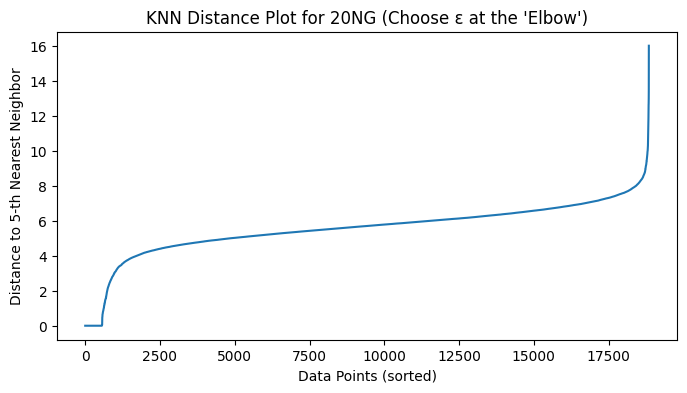

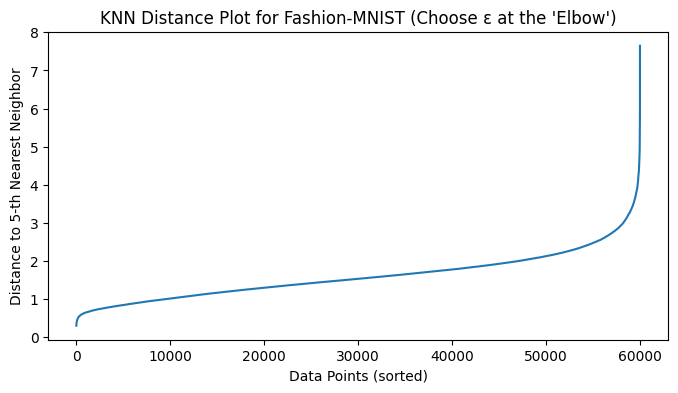

In [32]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

def plot_knn_distance(X, k=5, dataset_name="Dataset"):
    """
    Plots the k-nearest neighbor distances to estimate a good epsilon value for DBSCAN.
    """
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1])  # Sort distances for visualization

    plt.figure(figsize=(8, 4))
    plt.plot(distances)
    plt.xlabel("Data Points (sorted)")
    plt.ylabel(f"Distance to {k}-th Nearest Neighbor")
    plt.title(f"KNN Distance Plot for {dataset_name} (Choose ε at the 'Elbow')")
    plt.show()

# Run on 20NG and Fashion-MNIST
plot_knn_distance(X_20ng_reduced, k=5, dataset_name="20NG")
plot_knn_distance(X_fashion_reduced, k=5, dataset_name="Fashion-MNIST")

Tuning our DBSCAN parameters:

If too many clusters → Increase minPts (prevents small noise clusters).

If too few clusters → Decrease ε (forces DBSCAN to detect more clusters).

If clusters merge too much → Lower ε gradually.

In [38]:
# Define DBSCAN parameters for each dataset
dbscan_params = {
    "20NG": {"epsilon": 3.5, "minPts": 4},
    "Fashion-MNIST": {"epsilon": 1.4, "minPts": 30},
    "Household": {"epsilon": 0.6, "minPts": 8},
}

# Run DBSCAN on Each Dataset
datasets = {
    "20NG": X_20ng_reduced,
    "Fashion-MNIST": X_fashion_reduced,
    "Household": X_household_sampled
}

for dataset_name, params in dbscan_params.items():
    run_dbscan(datasets[dataset_name], dataset_name, params["epsilon"], params["minPts"])


Running DBSCAN on 20NG...
DBSCAN found 16 clusters in 20NG

Running DBSCAN on Fashion-MNIST...
DBSCAN found 10 clusters in Fashion-MNIST

Running DBSCAN on Household...
DBSCAN found 8 clusters in Household


EXTRA CREDIT -

1. Remove rare classes from FASHION
2. Select only a subset of topics from 20NG
3. Remove extreme power usage outliers from household data

In [24]:
from collections import Counter

print("Filtering Fashion-MNIST dataset based on class labels...")

# Load dataset with class labels
(X_train, y_train), (_, _) = fashion_mnist.load_data()

# Count number of samples per class
class_counts = Counter(y_train)
print(f"Original class distribution: {class_counts}")

# Define which classes to keep (Example: Keep only Shirts, Shoes, and Bags)
keep_classes = [0, 5, 9]  # 0=T-shirt/top, 5=Sandal, 9=Ankle boot

# Filter dataset based on class labels
mask = np.isin(y_train, keep_classes)
X_fashion_filtered = X_train[mask].reshape(-1, 784) / 255.0  # Flatten and normalize
y_fashion_filtered = y_train[mask]

print(f"Filtered dataset size: {X_fashion_filtered.shape}")

Filtering Fashion-MNIST dataset based on class labels...
Original class distribution: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Filtered dataset size: (18000, 784)


In [26]:
print("Filtering 20 Newsgroups dataset based on topics...")

# Load dataset with class labels
X_20ng, y_20ng = fetch_20newsgroups(subset="all", remove=("headers", "footers", "quotes"), return_X_y=True)

# Define topic categories to keep (Example: Keep only Technology & Science)
keep_topics = [4, 11, 15]  # Example: Electronics, Space, and Cryptography

# Filter dataset
mask = np.isin(y_20ng, keep_topics)
X_20ng_filtered_texts = np.array(X_20ng)[mask]  # Filtered text data

# Convert text to numerical features using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_20ng_filtered = vectorizer.fit_transform(X_20ng_filtered_texts).toarray()

# Apply PCA to reduce dimensions
pca_20ng = PCA(n_components=50)
X_20ng_filtered = pca_20ng.fit_transform(X_20ng_filtered)

print(f"Filtered 20NG dataset shape: {X_20ng_filtered.shape}")

Filtering 20 Newsgroups dataset based on topics...
Filtered 20NG dataset shape: (2951, 50)


In [27]:
print("Filtering Household dataset to remove extreme power outliers...")

# Compute quartiles
q1 = household_data[features].quantile(0.25)
q3 = household_data[features].quantile(0.75)
iqr = q3 - q1

# Define lower & upper bounds for outlier removal
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filter out extreme outliers
mask = (household_data[features] >= lower_bound) & (household_data[features] <= upper_bound)
household_filtered = household_data[features][mask.all(axis=1)]

# Sample 50,000 rows after filtering
X_household_filtered = household_filtered.sample(n=50000, random_state=42).to_numpy()

# Normalize data
X_household_filtered = StandardScaler().fit_transform(X_household_filtered)

print(f"Filtered Household dataset shape: {X_household_filtered.shape}")

Filtering Household dataset to remove extreme power outliers...
Filtered Household dataset shape: (50000, 7)


In [29]:
# Run DBSCAN on Filtered Datasets
datasets_filtered = {
    "20NG": X_20ng_filtered,
    "Fashion-MNIST": X_fashion_filtered,
    "Household": X_household_filtered
}

for dataset_name, params in dbscan_params.items():
    print(f"\nRunning DBSCAN on curated {dataset_name} dataset...")
    clusters = optimized_dbscan(datasets_filtered[dataset_name], params["epsilon"], params["minPts"])
    num_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
    print(f"DBSCAN found {num_clusters} clusters in {dataset_name} after filtering")


Running DBSCAN on curated 20NG dataset...
DBSCAN found 1 clusters in 20NG after filtering

Running DBSCAN on curated Fashion-MNIST dataset...


KeyboardInterrupt: 

**PROBLEM 8: Hierarchical Clustering**

Implement hierarchical clustering. Start the bottom of the hierarchy with all point (or at least 5000 sampled) and build the hierarchy by repeatedly "joining the closest" clusters with avg_dist or single_dist criteria up to one big cluster (full hierarchy). Then decide how to cut it for K=2 or K=5 or K=10 clusters and evaluate. Run on moons dataset.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.spatial.distance import pdist, squareform

# Generate Moons dataset
X, _ = make_moons(n_samples=5000, noise=0.05, random_state=42)

print(f"Moons dataset shape: {X.shape}")

Moons dataset shape: (5000, 2)


In [ ]:
import heapq
from scipy.spatial.distance import pdist, squareform

class HierarchicalClusteringOptimized:
    def __init__(self, linkage="average"):
        """
        Optimized Hierarchical Clustering using a priority queue (heap).

        Parameters:
        - linkage: "single" (minimum distance) or "average" (mean distance).
        """
        self.linkage = linkage
        self.clusters = None
        self.distances = None

    def fit(self, X):
        """
        Performs Optimized Hierarchical Clustering on dataset X.
        """
        n_samples = X.shape[0]
        self.clusters = {i: [i] for i in range(n_samples)}

        # Compute all pairwise distances once
        self.distances = squareform(pdist(X, metric="euclidean"))

        # Initialize priority queue (heap) with all distances
        heap = []
        for i in range(n_samples):
            for j in range(i + 1, n_samples):
                heapq.heappush(heap, (self.distances[i, j], i, j))  # Store (distance, cluster1, cluster2)

        merge_order = []

        while len(self.clusters) > 1:
            # Get the closest two clusters (smallest distance from heap)
            _, c1, c2 = heapq.heappop(heap)

            if c1 not in self.clusters or c2 not in self.clusters:
                continue  # Skip if either cluster was already merged

            # Merge clusters
            self.clusters[c1].extend(self.clusters[c2])
            del self.clusters[c2]

            # Store merge history
            merge_order.append((c1, c2))

            # Update heap with new distances for the merged cluster
            for c3 in list(self.clusters.keys()):
                if c3 == c1:
                    continue

                # Compute new distance based on linkage
                if self.linkage == "single":
                    new_dist = np.min([self.distances[p1, p2] for p1 in self.clusters[c1] for p2 in self.clusters[c3]])
                elif self.linkage == "average":
                    new_dist = np.mean([self.distances[p1, p2] for p1 in self.clusters[c1] for p2 in self.clusters[c3]])

                heapq.heappush(heap, (new_dist, c1, c3))

        return merge_order


In [ ]:
# Run hierarchical clustering with Average-Linkage
h_clust = HierarchicalClusteringOptimized(linkage="average")
merge_history = h_clust.fit(X)

print(f"Final number of clusters: {len(h_clust.clusters)}")

Final number of clusters: 1


In [ ]:
def get_clusters_at_k_fixed(merge_history, n_samples, k):
    """
    Extracts clusters when there are exactly 'k' clusters remaining.

    Fix: Adjusted to handle two-element tuples instead of three.
    """
    clusters = {i: [i] for i in range(n_samples)}

    for c1, c2 in merge_history:
        if len(clusters) == k:
            break
        clusters[c1].extend(clusters[c2])
        del clusters[c2]

    # Assign cluster labels
    labels = np.full(n_samples, -1)
    for cluster_id, indices in clusters.items():
        labels[indices] = cluster_id

    return labels


In [ ]:
from sklearn.metrics import silhouette_score

# Evaluate different cluster cuts
for k in [2, 5, 10]:
    cluster_labels_fixed = get_clusters_at_k_fixed(merge_history, X.shape[0], k)
    score = silhouette_score(X, cluster_labels_fixed)
    print(f"Silhouette Score for K={k}: {score:.4f}")


Silhouette Score for K=2: 0.4157
Silhouette Score for K=5: 0.4330
Silhouette Score for K=10: 0.4362


Silhouette scores indicate "moderate" clustering quality.


In [ ]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

In [ ]:
def plot_dendrogram(X, method="average", title="Hierarchical Clustering Dendrogram"):
    """
    Plots the dendrogram for hierarchical clustering.

    Parameters:
    - X: The dataset used for clustering.
    - method: Linkage method ('single', 'complete', 'average', 'ward').
    - title: Title of the dendrogram plot.
    """
    plt.figure(figsize=(12, 6))

    # Compute linkage matrix
    linkage_matrix = sch.linkage(X, method=method)

    # Plot dendrogram
    sch.dendrogram(linkage_matrix, truncate_mode="level", p=20)  # Show only top 20 levels for clarity
    plt.title(title)
    plt.xlabel("Data Points (Sample Index)")
    plt.ylabel("Distance (Linkage Height)")
    plt.show()

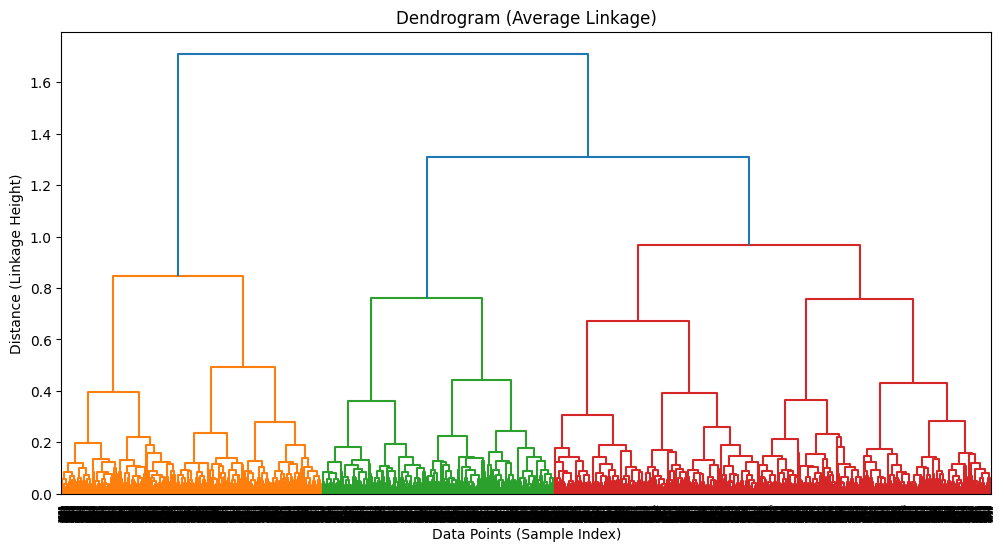

In [ ]:
plot_dendrogram(X, method="average", title="Dendrogram (Average Linkage)")


In [ ]:
from scipy.cluster.hierarchy import fcluster

# Cut the dendrogram at a threshold distance of 0.5
cluster_labels = fcluster(sch.linkage(X, method="average"), t=0.5, criterion="distance")

print(f"Number of clusters found: {len(set(cluster_labels))}")

Number of clusters found: 8
